# FaceNet Sample

## Pre requirement
install facenet-pytorch  <br/>
install pytorch,numpy,matplot,PIL

In [29]:
!python -m pip install --upgrade pip
!pip install facenet-pytorch

     |████████████████████████████████| 1.5 MB 3.3 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.3
    Uninstalling pip-20.3.3:
      Successfully uninstalled pip-20.3.3
distutils: /home/hank/anaconda3/envs/python_36/include/python3.6m/UNKNOWN
sysconfig: /home/hank/anaconda3/envs/python_36/include/python3.6m
user = False
home = None
root = None
prefix = None
distutils: /home/hank/anaconda3/envs/python_36/include/python3.6m/UNKNOWN
sysconfig: /home/hank/anaconda3/envs/python_36/include/python3.6m
user = False
home = None
root = None
prefix = None


## Sample Image
These are image to compare similarity, all of them are the same person except for index 5 and 6.

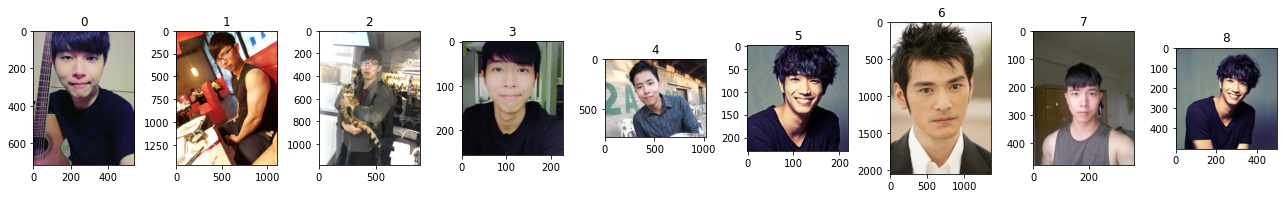

In [34]:
from PIL import Image
import matplotlib.pyplot as plt
import os
images = []
for current_folder_name,sub_folder_names,file_names in os.walk('content'):
    for file_name in file_names:
        images.append(os.path.join(current_folder_name,file_name))
    break

fig,ax = plt.subplots(1,len(images),figsize=(18,18))
fig.tight_layout()
for index,file_path in enumerate(images):
    image = Image.open(file_path)
    ax[index].imshow(image)
    ax[index].title.set_text(index)

## MTCNN
Capture facial feature of image <br/>
Before send image to model, resize it to (128,128)

In [35]:
from torchvision import transforms
img_size = (128,128)
resize = transforms.Compose([
    transforms.Resize(img_size),
])

In [36]:
from facenet_pytorch import MTCNN,InceptionResnetV1
mtcnn = MTCNN()

output_list = []
for file_name in images:
    image = Image.open(file_name)
    image = resize(image)
    output = mtcnn(image)
    output_list.append(output)

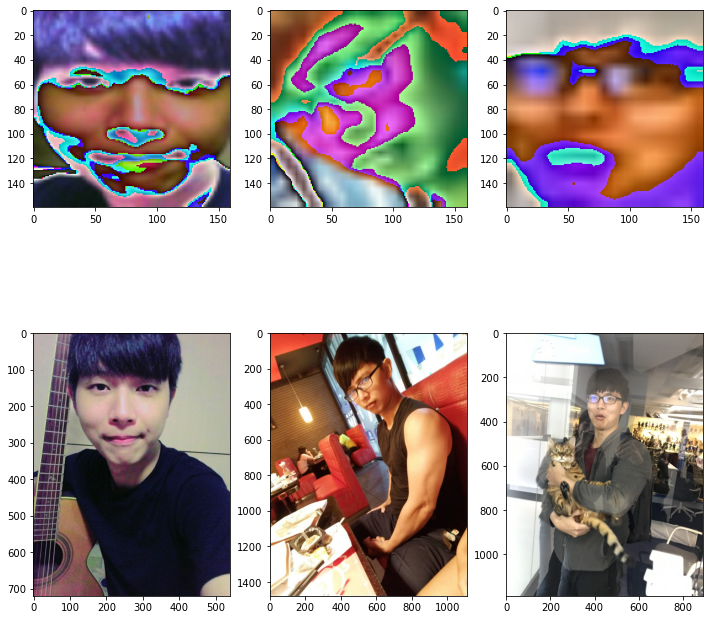

In [38]:
import numpy as np
to_PIL = transforms.ToPILImage()
plt.figure(figsize=(12,12))
for index in range(3):
    plt.subplot(2,3,index+1)
    plt.imshow(to_PIL(output_list[index]))

for index in range(3,6):
    plt.subplot(2,3,index+1)
    plt.imshow(to_PIL(np.array(Image.open(images[index-3]))))


## Compute Similarity


### preprocessing image

In [39]:
import torch
input = output_list[0].unsqueeze(0)
for output in output_list[1:]:
    input = torch.cat([input,output.unsqueeze(0)],dim = 0)

### get embedding

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
logits = resnet(input.to(device))

### compute cosine similarity

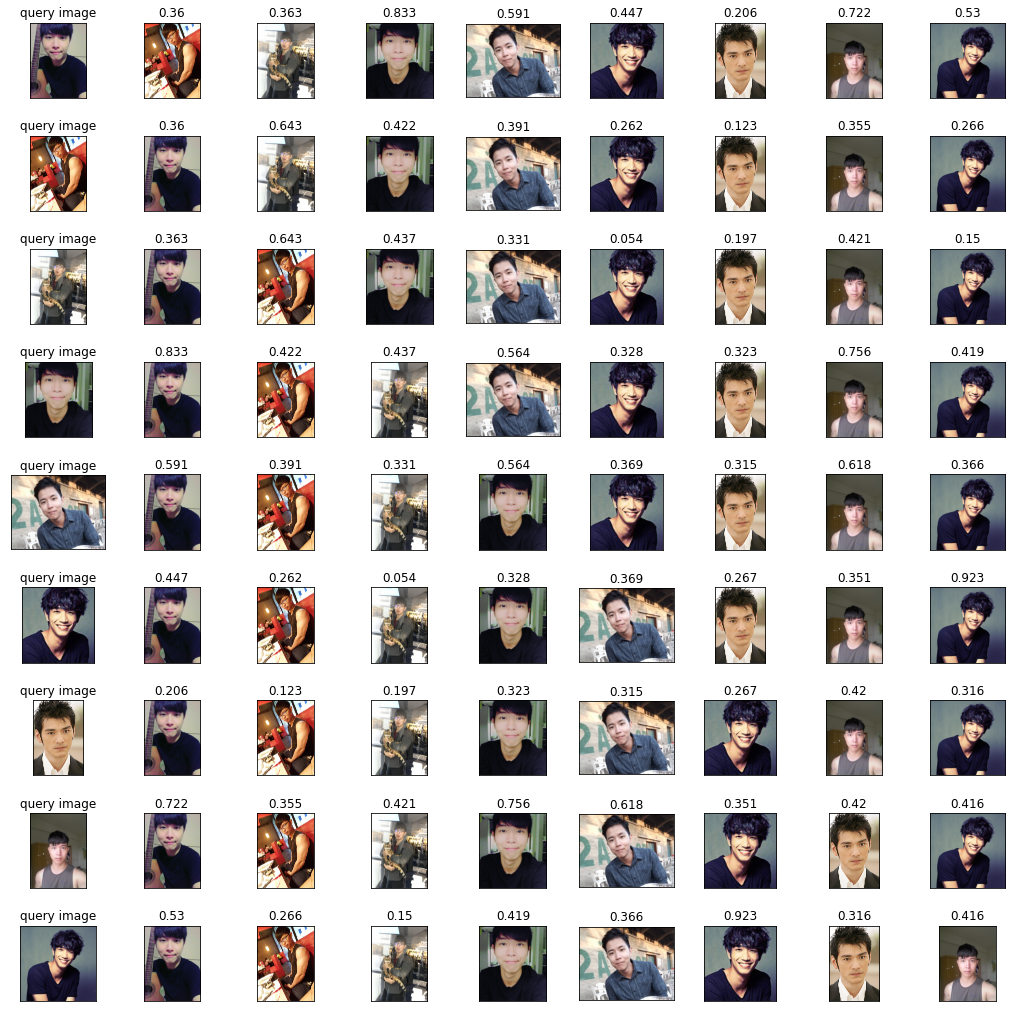

In [48]:
import numpy as np
def get_vector_length(vector):
    return np.sqrt(sum(np.square(vector)))

def get_cosine_similarity(query_img_vector,doc_img_vector):
    dot_product = np.dot(query_img_vector.detach().cpu(),doc_img_vector.detach().cpu())
    query_img_length = get_vector_length(query_img_vector.detach().cpu())
    doc_img_length = get_vector_length(doc_img_vector.detach().cpu())
    cosine_similarity = dot_product / (query_img_length*doc_img_length)
    return cosine_similarity

plot_index = 0
plt.figure(figsize=(18,18))
plt.subplots_adjust(hspace=.5)
for query_index,query_img_vector in enumerate(logits):
    plot_index += 1
    plt.subplot(len(logits),len(logits),plot_index)
    plt.imshow(Image.open(images[query_index]))
    plt.title('query image')
    plt.xticks([])
    plt.yticks([])
    for index,doc_img_vector in enumerate(logits):
        if not (doc_img_vector == query_img_vector).all():
            cosine_similarity = get_cosine_similarity(query_img_vector.detach().cpu(),doc_img_vector.detach().cpu())

          # plot
            plot_index += 1
            plt.subplot(len(logits),len(logits),plot_index)
            plt.imshow(Image.open(images[index]))
            plt.title(round(cosine_similarity.item(),3))
            plt.xticks([])
            plt.yticks([])